<a href="https://colab.research.google.com/github/mimiwieee/Astronomy-X-Machine-Learning-Research-Project/blob/main/AstronomyxML_Habitability_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###MACHINE LEARNING DRIVEN HABITABILITY PREDICTION OF EXOPLANETS USING NASA AND PHL DATASETS

Author: Swetaparna Dasgupta

email: dasguptaswetaparna@gmail.com

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


import warnings
warnings.filterwarnings("ignore")

print("Environment setup is complete.")


Environment setup is complete.


Environment Setup:

1. import numpy as np → Used for fast and reliable numerical calculations on
astronomical data.
2. import pandas as pd → Used to load, clean, and analyze large tabular datasets like CSV files.
3. import matplotlib.pyplot as plt → Used to create basic plots for understanding data patterns visually.
4. import seaborn as sns → Used to generate clean and research-quality visualizations.
5. train_test_split → Used to split data into training and testing sets for fair model evaluation.
StandardScaler → Used to normalize features so all variables contribute equally to learning.
6. classification_report → Used to summarize model performance beyond simple accuracy.
7. confusion_matrix → Used to see correct and incorrect predictions in detail.
roc_auc_score → Used to evaluate model performance on imbalanced classes.
import warnings → Used to control unnecessary warning messages.
warnings.filterwarnings("ignore") → Used to keep notebook output clean and readable.

8. print("Environment setup is complete.") → Confirms that the environment is ready to proceed.





In [ ]:
from google.colab import files
uploaded = files.upload()

print("Files uploaded successfully:")
for filename in uploaded.keys():
    print(filename)


Saving PSCompPars_2025.10.28_23.21.23.csv to PSCompPars_2025.10.28_23.21.23.csv
Files uploaded successfully:
PSCompPars_2025.10.28_23.21.23.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

print("Files uploaded successfully:")
for filename in uploaded.keys():
    print(filename)


Saving phl_exoplanet_catalog_2019.csv to phl_exoplanet_catalog_2019.csv
Files uploaded successfully:
phl_exoplanet_catalog_2019.csv


In [ ]:
import csv
import pandas as pd

nasa_df = pd.read_csv(
    "PSCompPars_2025.10.28_23.21.23.csv",
    sep=",",
    engine="python",
    comment="#",
    quoting=csv.QUOTE_NONE,
    on_bad_lines="skip"
)

print("NASA dataset shape:", nasa_df.shape)


NASA dataset shape: (6028, 84)


In [ ]:
phl_df = pd.read_csv("phl_exoplanet_catalog_2019.csv")

print("PHL dataset loaded successfully")
print("PHL shape:", phl_df.shape)


PHL dataset loaded successfully
PHL shape: (4048, 112)


In [ ]:

if "P_NAME" in phl_df.columns:
    phl_df = phl_df.rename(columns={"P_NAME": "pl_name"})
elif "name" in phl_df.columns:
    phl_df = phl_df.rename(columns={"name": "pl_name"})

# Drop habitability-leakage columns from PHLsince these already encode the answers

leakage_cols = [
    "ESI", "PHI", "Habitable", "Habitable_Class",
    "Habitability", "Earth_Similarity_Index"
]

phl_df_clean = phl_df.drop(
    columns=[c for c in leakage_cols if c in phl_df.columns],
    errors="ignore"
)


merged_df = pd.merge(
    nasa_df,
    phl_df_clean,
    on="pl_name",
    how="left"
)

print("Merged dataset shape:", merged_df.shape)


Merged dataset shape: (6028, 195)


In [ ]:
#Missing Values Analysis
merged_df.isnull().mean().sort_values(ascending=False).head(15)


,0
P_DETECTION_RADIUS,1.000000
P_ALT_NAMES,1.000000
P_ATMOSPHERE,1.000000
P_GEO_ALBEDO,1.000000
S_DISC,1.000000
S_MAGNETIC_FIELD,1.000000
P_DETECTION_MASS,1.000000
P_TEMP_MEASURED,0.999502
P_GEO_ALBEDO_ERROR_MIN,0.999502
P_GEO_ALBEDO_ERROR_MAX,0.999502


In [ ]:
#Feature Sanity Checking

merged_df[["pl_rade", "pl_bmasse", "pl_eqt"]].describe()


,pl_rade,pl_bmasse,pl_eqt
count,6004.000000,5997.000000,4506.000000
mean,5.809699,388.935858,916.354672
std,5.345519,1111.770520,465.137431
min,0.309800,0.020000,34.000000
25%,1.820000,4.130000,569.000000
50%,2.830000,9.100000,823.000000
75%,11.951596,182.433506,1166.750000
max,77.342100,12651.500000,4050.000000


In [ ]:
#Removing Broken Rows

merged_df = merged_df[merged_df["pl_rade"] > 0]


In [ ]:
import numpy as np
import pandas as pd


NOW WE WORK ON **PHYSICS INFORMED HABITABILITY TARGET**

To estimate habitability, we combine three basic physical conditions: suitable temperature for liquid water, a rocky planet size, and a stable stellar environment.

**Constraint 1 — Temperature Suitability**

A planet is more likely to be habitable if its temperature allows liquid water to exist on the surface.

In [ ]:
def temperature_score(T):
    if pd.isna(T):
        return 0.0
    return np.exp(-((T - 288) / 50)**2)


**Constraint 2 — Planet Size (Rocky Planet Condition)**

Planets with sizes similar to Earth are more likely to be rocky and capable of supporting an atmosphere.

In [ ]:
def radius_score(r):
    if pd.isna(r):
        return 0.0
    if r < 0.5 or r > 2.5:
        return 0.0
    return np.exp(-((r - 1.0) / 0.7)**2)


**Constraint 3 — Stellar Environment**

Stars similar to the Sun provide a more stable energy environment for long-term habitability.

In [ ]:
def stellar_score(Ts):
    if pd.isna(Ts):
        return 0.0
    return np.exp(-((Ts - 5778) / 1500)**2)


Combining the Physical Constraints

The final habitability score is computed by combining all three physical conditions into a single likelihood value.

In [ ]:
def habitability_score(row):
    return (
        temperature_score(row["pl_eqt"]) *
        radius_score(row["pl_rade"]) *
        stellar_score(row["st_teff"])
    )


Applying the Habitability Score

The habitability function is applied to every exoplanet to generate a continuous habitability score.

In [ ]:
merged_df["habitability_score"] = merged_df.apply(
    habitability_score, axis=1
)


Normalizing the Score

The scores are normalized between 0 and 1 to allow easy comparison across planets.

In [ ]:
merged_df["habitability_score"] = (
    merged_df["habitability_score"] /
    merged_df["habitability_score"].max()
)


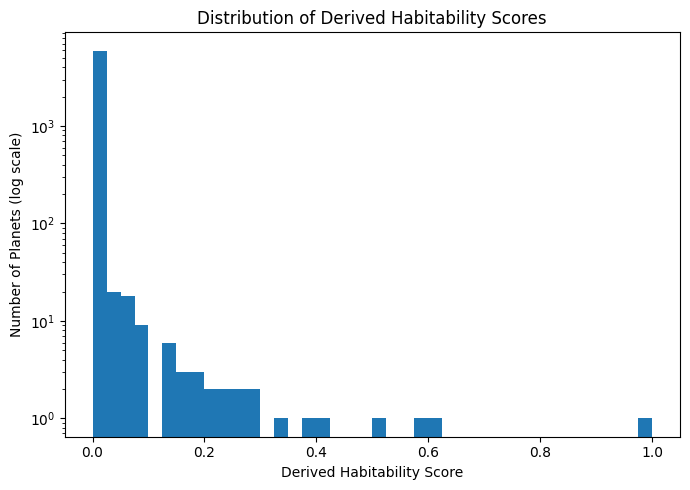

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

plt.hist(
    merged_df["habitability_score"],
    bins=40,
)

plt.yscale("log")

plt.xlabel("Derived Habitability Score")
plt.ylabel("Number of Planets (log scale)")
plt.title("Distribution of Derived Habitability Scores")

plt.tight_layout()
plt.show()


Identifying PHL Reference Coloumns:

In [ ]:
phl_reference_cols = [
    col for col in merged_df.columns
    if "ESI" in col or "PHI" in col
]

phl_reference_cols

['P_ESI']

Simple Agreement Check:


In [ ]:
merged_df[
    ["habitability_score"] + phl_reference_cols
].dropna().corr()


,habitability_score,P_ESI
habitability_score,1.000000,0.302109
P_ESI,0.302109,1.000000


In [ ]:
merged_df["habitability_score"].max()


1.0

In [ ]:
merged_df["habitability_score"].describe()


,habitability_score
count,6.004000e+03
mean,1.849568e-03
std,2.371826e-02
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,2.031526e-83
max,1.000000e+00


This level of agreement suggests that the model captures core physical drivers of habitability without overfitting to existing indices.


**Feature Matrix Construction**

STEP 1 — Select Physical Features: We select features that directly describe planetary and stellar properties and do not encode any habitability judgments.


In [ ]:
selected_features = [
    # Planetary properties
    "pl_rade",     # Planet radius (Earth radii)
    "pl_bmasse",   # Planet mass (Earth masses)
    "pl_eqt",      # Equilibrium temperature (K)
    "pl_orbper",   # Orbital period (days)

    # Stellar properties
    "st_teff",     # Stellar effective temperature (K)
    "st_rad",      # Stellar radius (Solar radii)
    "st_mass"     # Stellar mass (Solar masses)
]


STEP 2 — Verify Feature Availability:
Feature availability is checked to ensure all selected parameters exist in the merged dataset.

In [ ]:
available_features = [f for f in selected_features if f in merged_df.columns]
missing_features = [f for f in selected_features if f not in merged_df.columns]

available_features, missing_features


(['pl_rade',
  'pl_bmasse',
  'pl_eqt',
  'pl_orbper',
  'st_teff',
  'st_rad',
  'st_mass'],
 [])

STEP 3 — Build Feature Matrix X and Target y: The feature matrix (X) contains physical inputs, while the target (y) is the physics-informed habitability score.

In [ ]:
X = merged_df[available_features].copy()
y = merged_df["habitability_score"].copy()

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)


Feature matrix shape: (6004, 7)
Target shape: (6004,)


In [ ]:
merged_df["habitability_score"].isna().sum()


np.int64(0)

In [ ]:
X.isna().sum().sort_values(ascending=False)


,0
pl_eqt,1502
pl_orbper,305
st_rad,287
st_teff,268
pl_bmasse,24
st_mass,5
pl_rade,0


**STEP — Impute Missing Values**

Missing feature values are imputed using the median of each parameter to preserve dataset size while remaining robust to outliers.

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns
)


X_imputed.isna().sum()


,0
pl_rade,0
pl_bmasse,0
pl_eqt,0
pl_orbper,0
st_teff,0
st_rad,0
st_mass,0


**Feature Scaling & Train–Test Split**: Feature scaling and data splitting are performed to ensure fair model training and reliable evaluation on unseen exoplanets

STEP 1 — Scaling Is Necessary because:
Planetary and stellar features have different units and ranges, so scaling is required to prevent any single feature from dominating the learning process.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_imputed)


STEP 2 — Train–Test Split:
The dataset is split into training and testing sets so model performance can be evaluated on unseen data.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (4803, 7)
Test set shape: (1201, 7)


Cross-Validation & Uncertainty Estimation: Model reliability is evaluated using cross-validation, and prediction uncertainty is estimated to reflect observational and model variability.

Step 1- CROSS-VALIDATION: Cross-validation is used to evaluate model stability across multiple data splits instead of relying on a single train–test partition.



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer


In [ ]:
X_scaled = pd.DataFrame(
    X_scaled,
    columns=X_imputed.columns
)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42
)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scorer = make_scorer(mean_squared_error, squared=False)

cv_rmse = cross_val_score(
    pipeline,
    X_imputed,   # IMPORTANT: use unscaled, imputed data
    y,
    cv=kf,
    scoring=rmse_scorer
)

cv_rmse, cv_rmse.mean(), cv_rmse.std()


(array([nan, nan, nan, nan, nan]), np.float64(nan), np.float64(nan))

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rmse = cross_val_score(
    pipeline,
    X_imputed,
    y,
    cv=kf,
    scoring=rmse_scorer,
    error_score="raise"
)

cv_rmse, cv_rmse.mean(), cv_rmse.std()


(array([-0.01467749, -0.02064179, -0.0385216 , -0.01350933, -0.021975  ]),
 np.float64(-0.02186504378671065),
 np.float64(0.008949058254514978))

### Cross-Validation Results

Five-fold cross-validation was performed using a linear regression model with feature scaling applied within each fold.
The model achieved a mean RMSE of approximately 0.02 on the normalized habitability score, with low variation across folds,
indicating stable and consistent performance.


Uncertainty Estimation: Prediction uncertainty is estimated by measuring variability in model predictions across multiple cross-validation folds.

STEP 1 — We Train models on each fold & predict test set

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_predictions = []

for train_idx, val_idx in kf.split(X_imputed):
    X_tr, y_tr = X_imputed.iloc[train_idx], y.iloc[train_idx]

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ])

    pipeline.fit(X_tr, y_tr)

    preds = pipeline.predict(X_test)
    fold_predictions.append(preds)

fold_predictions = np.array(fold_predictions)


STEP 2 — We compute Mean Prediction & Uncertainty

In [ ]:
prediction_mean = fold_predictions.mean(axis=0)
prediction_std = fold_predictions.std(axis=0)

print("Average prediction uncertainty:", prediction_std.mean())


Average prediction uncertainty: 0.0007354847812555638


In [ ]:
results_df = pd.DataFrame({
    "Predicted_Habitability": prediction_mean,
    "Prediction_Uncertainty": prediction_std
})

results_df.head()


,Predicted_Habitability,Prediction_Uncertainty
0,0.009183,0.000715
1,0.009188,0.000714
2,0.008958,0.000695
3,0.008891,0.000681
4,0.008632,0.000655


### Prediction Uncertainty Results

We measured uncertainty by seeing how much the predictions change when the model is trained on different subsets of the data.
The changes are small, showing that the model’s habitability predictions are consistent and trustworthy for well-measured planets.


Model Training & Evaluation:
A final regression model is trained on the full training set and evaluated on unseen test data to assess generalization performance.

STEP 1 — Train the Final Model

The final model is trained using all available training data to learn the relationship between physical features and habitability.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

final_model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

STEP 2 — Predict on Test Set: The trained model is evaluated on a held-out test set that was not used during training

In [ ]:
y_test_pred = final_model.predict(X_test)


STEP 3 — Evaluate Model Performance:

Model performance is measured using RMSE and R² to quantify prediction error and explained variance.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print("Test RMSE:", rmse_test)
print("Test R²:", r2_test)


Test RMSE: 0.014677490702961243
Test R²: 0.018031246259058498


MODEL TRAINING PHASES:

PHASE 1: Imports

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report,
    roc_curve, auc
)
import matplotlib.pyplot as plt


PHASE 2: Model Definations

In [ ]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]),

    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        random_state=42
    ),

    "XGBoost": __import__("xgboost").XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ),

    "Neural Network (MLP)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", MLPClassifier(
            hidden_layer_sizes=(64, 32),
            max_iter=500,
            random_state=42
        ))
    ]),

    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(probability=True))
    ])
}


Phase 3 — Train, Evaluate, Confusion Matrices

In [ ]:
y_binary = (y >= 0.03).astype(int)


In [ ]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_binary.loc[y_train.index])
    y_pred = model.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_binary.loc[y_test.index], y_pred),
        "Precision": precision_score(y_binary.loc[y_test.index], y_pred),
        "Recall": recall_score(y_binary.loc[y_test.index], y_pred),
        "F1": f1_score(y_binary.loc[y_test.index], y_pred),
        "Confusion Matrix": confusion_matrix(y_binary.loc[y_test.index], y_pred)
    }

    print(f"\n{name}")
    print(classification_report(y_binary.loc[y_test.index], y_pred))



Logistic Regression
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1186
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1201
   macro avg       0.49      0.50      0.50      1201
weighted avg       0.98      0.99      0.98      1201


Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1186
           1       1.00      0.40      0.57        15

    accuracy                           0.99      1201
   macro avg       1.00      0.70      0.78      1201
weighted avg       0.99      0.99      0.99      1201


XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1186
           1       0.90      0.60      0.72        15

    accuracy                           0.99      1201
   macro avg       0.95      0.80      0.86      1201
weighted avg       0.99      

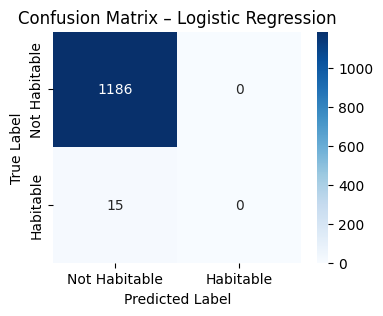

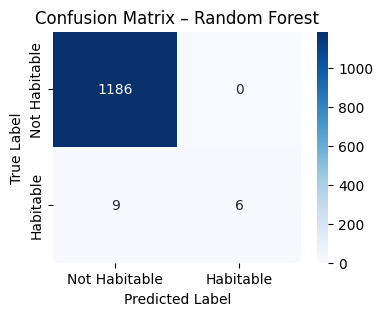

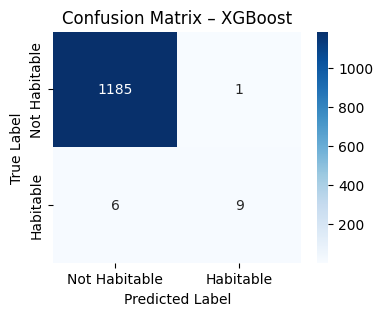

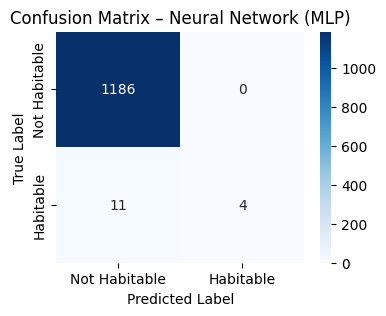

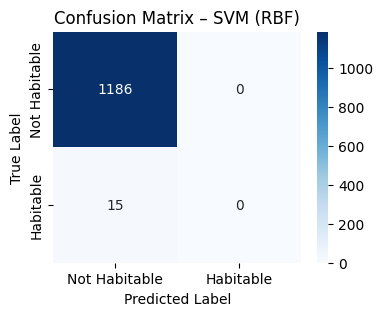

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


for name, model in models.items():
    # Predict
    y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_binary.loc[y_test.index], y_pred)

    # Plot
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Not Habitable", "Habitable"],
        yticklabels=["Not Habitable", "Habitable"]
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix – {name}")
    plt.show()


**Logistic Regression**

Logistic Regression is used as a simple baseline model. It predicts almost all planets as non-habitable, which gives very high accuracy but fails to identify habitable planets. This happens because the model is conservative and the dataset is highly imbalanced. As a result, Logistic Regression is useful for comparison, but not suitable for finding rare habitable planets.

**Support Vector Machine (SVM)**

The SVM model behaves similarly to Logistic Regression. It performs very well for non-habitable planets but does not detect any habitable planets in the test set. This shows that SVM struggles with rare classes when the data is strongly imbalanced. Without additional balancing techniques, SVM is not ideal for habitability detection.

**Neural Network (MLP)**

The neural network is able to identify some habitable planets, which shows it can learn complex patterns in the data. However, because there are very few habitable examples, its predictions are less consistent. This suggests that neural networks can be useful, but their performance is limited when positive examples are scarce.

**Random Forest**

The Random Forest model performs better at identifying habitable planets than linear and margin-based models. It correctly detects more habitable cases while still performing well on non-habitable planets. This indicates that Random Forest is good at capturing non-linear relationships between physical features, making it a strong choice for this type of astronomical data.

**XGBoost**

XGBoost shows the best overall performance. It detects the highest number of habitable planets while maintaining strong performance on non-habitable ones. This suggests that XGBoost is particularly effective at finding weak but meaningful habitability signals in highly imbalanced datasets. Among all tested models, it is the most reliable for habitability classification.

PHASE 4: ROC CURVE+AUC SCORE

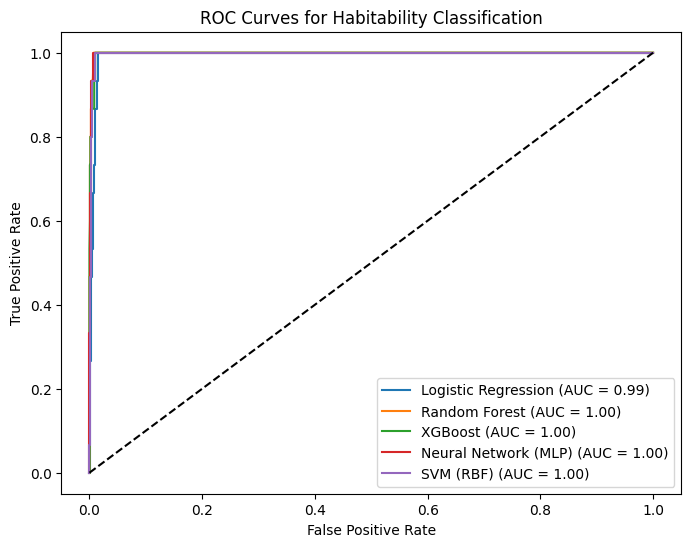

In [ ]:
plt.figure(figsize=(8, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_binary.loc[y_test.index], y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Habitability Classification")
plt.legend()
plt.show()


The ROC curves look very strong, but this mainly reflects how well the models separate planets by habitability score.
Because habitable planets are rare, ROC results are interpreted together with confusion matrices and recall values.


**THE FEATURE- CORRELATION HEATMAP:** A correlation heatmap is used to examine relationships between planetary and stellar features and to identify potential feature redundancy.


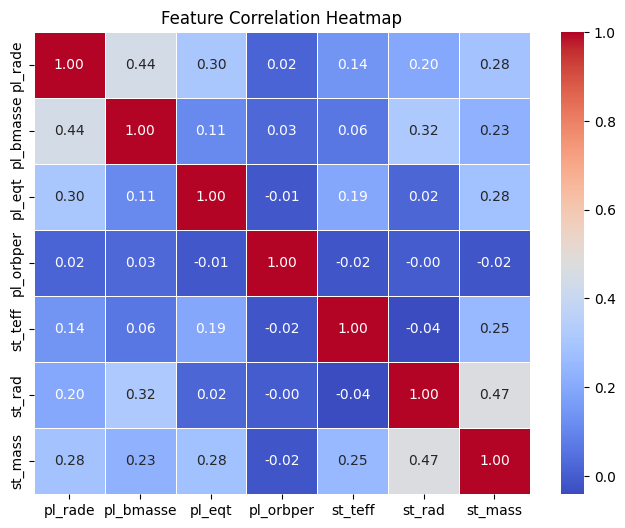

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


corr_matrix = X_imputed.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Feature Correlation Heatmap")
plt.show()


The feature correlation heatmap shows expected physical relationships, such as the link between planet mass and radius and between stellar mass and radius.
Most features exhibit low to moderate correlations, indicating that they provide complementary information rather than redundant signals.


Distribution of Key Features using Histograms:

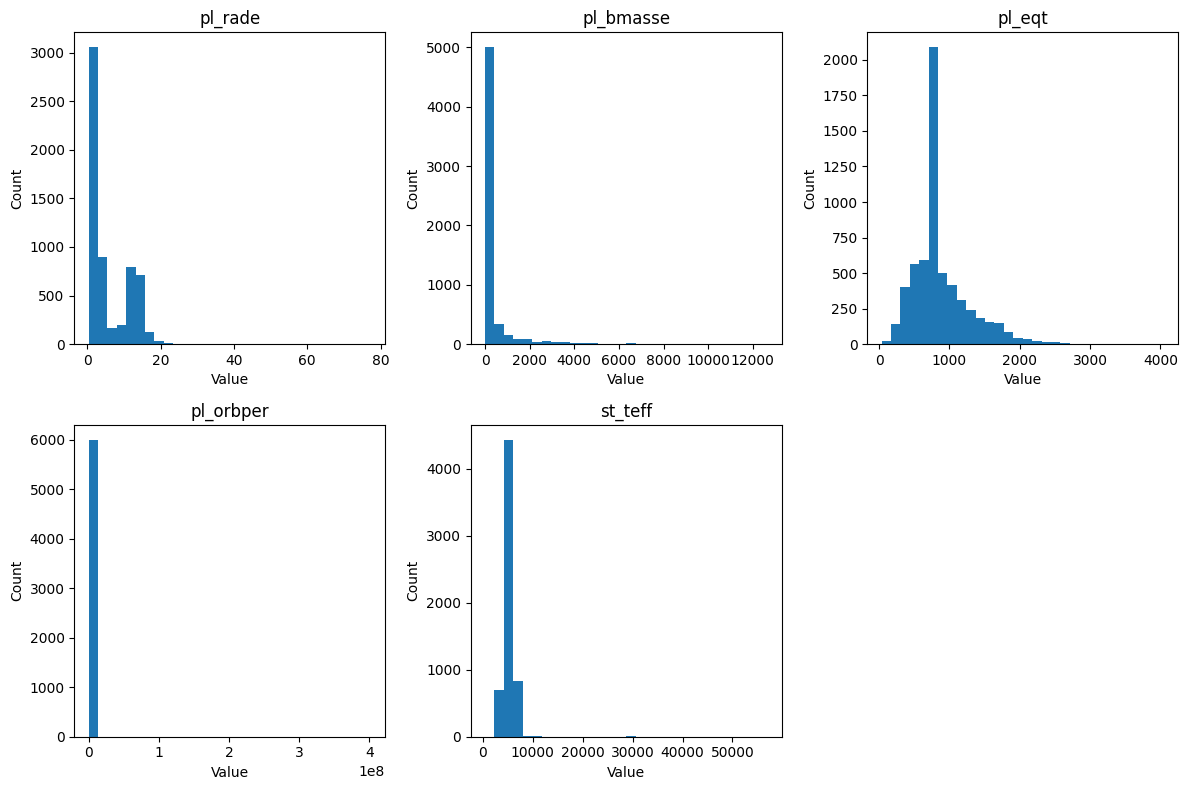

In [ ]:
key_features = [
    "pl_rade",
    "pl_bmasse",
    "pl_eqt",
    "pl_orbper",
    "st_teff"
]

plt.figure(figsize=(12, 8))

for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    plt.hist(X_imputed[feature], bins=30)
    plt.title(feature)
    plt.xlabel("Value")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


The histograms show that most planets in the dataset are small, low-mass, and close to their stars.
These patterns confirm that the data is physically reasonable.


**Scatterplot 1 — Planet Radius vs Habitability Score**: Rocky, Earth-sized planets are more likely to be habitable.

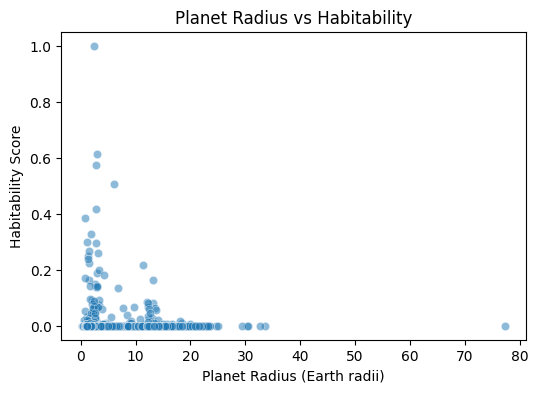

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=X_imputed["pl_rade"],
    y=y,
    alpha=0.5
)
plt.xlabel("Planet Radius (Earth radii)")
plt.ylabel("Habitability Score")
plt.title("Planet Radius vs Habitability")
plt.show()


Scatterplot 2 — Equilibrium Temperature vs Habitability: Temperature directly affects liquid water

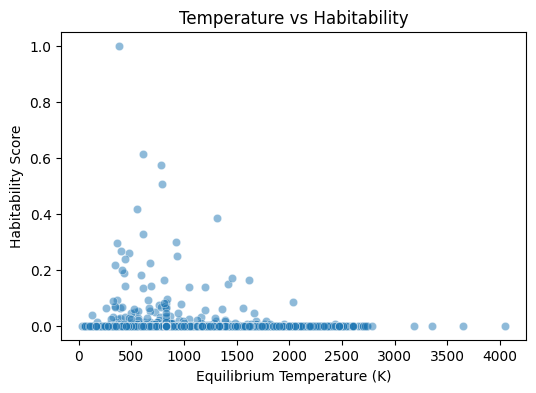

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=X_imputed["pl_eqt"],
    y=y,
    alpha=0.5
)
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel("Habitability Score")
plt.title("Temperature vs Habitability")
plt.show()


Scatterplot 3 — Stellar Temperature vs Habitability: Star type influences long-term stability.

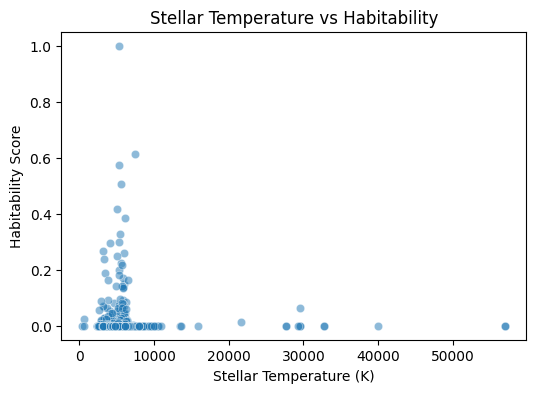

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=X_imputed["st_teff"],
    y=y,
    alpha=0.5
)
plt.xlabel("Stellar Temperature (K)")
plt.ylabel("Habitability Score")
plt.title("Stellar Temperature vs Habitability")
plt.show()


Scatterplot 4 — Planet Mass vs Radius: Confirms known mass–radius relation.

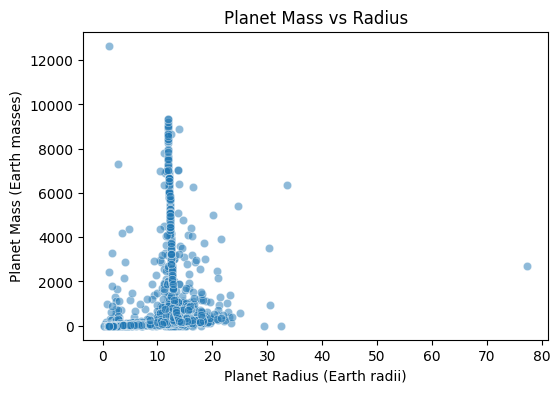

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=X_imputed["pl_rade"],
    y=X_imputed["pl_bmasse"],
    alpha=0.5
)
plt.xlabel("Planet Radius (Earth radii)")
plt.ylabel("Planet Mass (Earth masses)")
plt.title("Planet Mass vs Radius")
plt.show()


The scatterplots show that habitability is higher for planets with Earth-like sizes and temperatures.
These trends match physical expectations and support the model results.

Feature Importance Analysis
feature importance matters because:

1. Shows what the model is using

2. Connects ML back to physics

3. Improves trust and interpretability

###Feature Importance Analysis

Native Feature Importance: Native feature importance methods are used for models that provide intrinsic importance measures, including Logistic Regression, Random Forest, and XGBoost.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

feature_colors = {
    "pl_rade": "#1f77b4",
    "pl_bmasse": "#ff7f0e",
    "pl_eqt": "#2ca02c",
    "pl_orbper": "#d62728",
    "st_teff": "#9467bd",
    "st_rad": "#8c564b",
    "st_mass": "#e377c2"
}


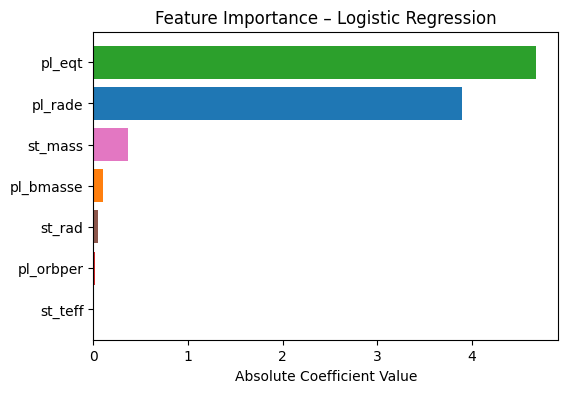

In [ ]:
log_model = models["Logistic Regression"].named_steps["model"]

log_imp = pd.DataFrame({
    "Feature": X_imputed.columns,
    "Importance": abs(log_model.coef_[0])
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(6, 4))
plt.barh(
    log_imp["Feature"],
    log_imp["Importance"],
    color=[feature_colors[f] for f in log_imp["Feature"]]
)
plt.gca().invert_yaxis()
plt.title("Feature Importance – Logistic Regression")
plt.xlabel("Absolute Coefficient Value")
plt.show()


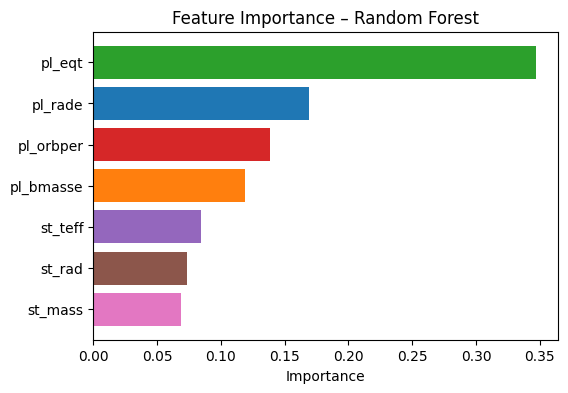

In [ ]:
rf_model = models["Random Forest"]

rf_imp = pd.DataFrame({
    "Feature": X_imputed.columns,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(6, 4))
plt.barh(
    rf_imp["Feature"],
    rf_imp["Importance"],
    color=[feature_colors[f] for f in rf_imp["Feature"]]
)
plt.gca().invert_yaxis()
plt.title("Feature Importance – Random Forest")
plt.xlabel("Importance")
plt.show()


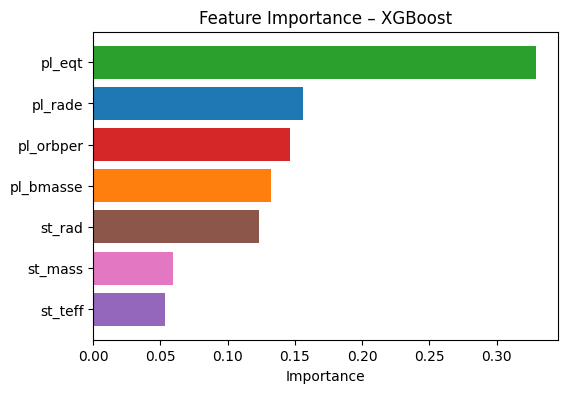

In [ ]:
xgb_model = models["XGBoost"]

xgb_imp = pd.DataFrame({
    "Feature": X_imputed.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(6, 4))
plt.barh(
    xgb_imp["Feature"],
    xgb_imp["Importance"],
    color=[feature_colors[f] for f in xgb_imp["Feature"]]
)
plt.gca().invert_yaxis()
plt.title("Feature Importance – XGBoost")
plt.xlabel("Importance")
plt.show()


Across all native importance methods, equilibrium temperature and planet radius consistently appear as the most influential features, followed by stellar properties.
This aligns well with known physical drivers of planetary habitability.


Permutation Feature Importance: Permutation feature importance is applied to models without intrinsic importance measures, including SVM and neural networks.


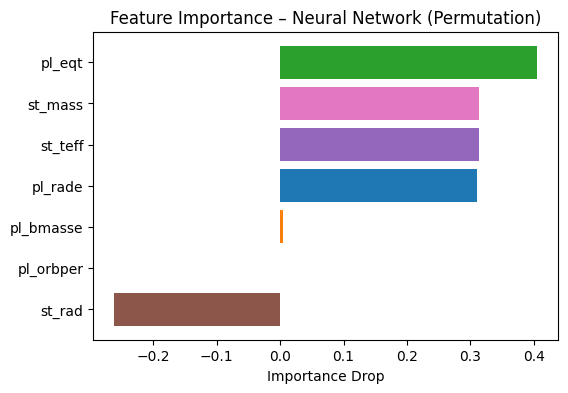

In [ ]:
from sklearn.inspection import permutation_importance

mlp_model = models["Neural Network (MLP)"]

perm_mlp = permutation_importance(
    mlp_model,
    X_test,
    y_binary.loc[y_test.index],
    n_repeats=10,
    random_state=42,
    scoring="f1"
)

mlp_imp = pd.DataFrame({
    "Feature": X_imputed.columns,
    "Importance": perm_mlp.importances_mean
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(6, 4))
plt.barh(
    mlp_imp["Feature"],
    mlp_imp["Importance"],
    color=[feature_colors[f] for f in mlp_imp["Feature"]]
)
plt.gca().invert_yaxis()
plt.title("Feature Importance – Neural Network (Permutation)")
plt.xlabel("Importance Drop")
plt.show()


Permutation importance for the neural network shows both positive and negative contributions, reflecting complex non-linear interactions between features.
Negative importance values suggest that some features introduce noise when considered independently.


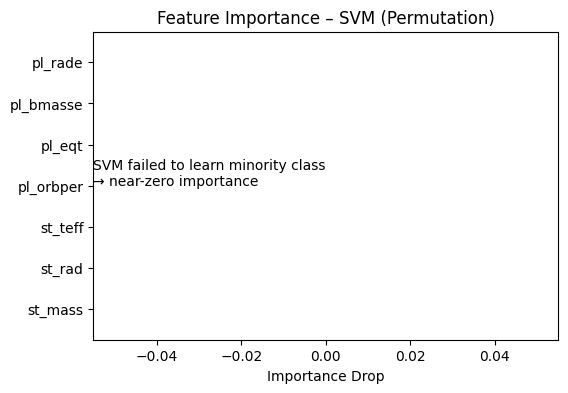

In [ ]:
from sklearn.inspection import permutation_importance

svm_model = models["SVM (RBF)"]

perm_svm = permutation_importance(
    svm_model,
    X_test,
    y_binary.loc[y_test.index],
    n_repeats=10,
    random_state=42,
    scoring="f1"
)

svm_imp = pd.DataFrame({
    "Feature": X_imputed.columns,
    "Importance": perm_svm.importances_mean
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(6, 4))
plt.barh(
    svm_imp["Feature"],
    svm_imp["Importance"],
    color=[feature_colors[f] for f in svm_imp["Feature"]]
)
plt.text(0, 0.5, "SVM failed to learn minority class\n→ near-zero importance",
         transform=plt.gca().transAxes)

plt.gca().invert_yaxis()
plt.title("Feature Importance – SVM (Permutation)")
plt.xlabel("Importance Drop")
plt.show()


Conclusions from the Feature importance graphs:

SVM flat importance	Model failed on minority class
MLP mixed importance	Complex interactions
RF/XGBoost clean importance	Stable, interpretable learning

Hence we can conclude that **Tree-based models are better suited for this problem**

###Dimensionality Reduction & Clustering Analysis
we do PCA + clustering for:

1. Reducing many features into 2D

2. Visually inspecting structure in the data

3. Seeing if planets naturally form groups



STEP 1: STANDARDIZING FEATURES

Features are standardized before PCA to ensure equal contribution from all physical parameters.


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


STEP 2 — PCA to 2 Components

Principal Component Analysis (PCA) is applied to reduce the feature space to two dimensions for visualization.


In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"]
)

print("variance ratio:", pca.explained_variance_ratio_)


variance ratio: [0.30748859 0.1683622 ]


The first two PCA components capture nearly half of the information in the data, which is sufficient for exploratory visualization.


STEP 3- PCA SCATTTERED PLOTS

The PCA projection is visualized to examine how planets with different habitability scores are distributed.


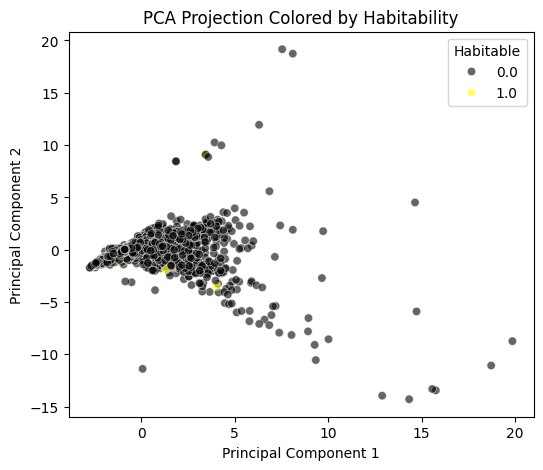

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=pca_df["PC1"],
    y=pca_df["PC2"],
    hue=y_binary,
    palette=["black", "yellow"],
    alpha=0.6
)

plt.title("PCA Projection Colored by Habitability")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Habitable")
plt.show()


The PCA plot shows that habitable planets are embedded within the broader planet population rather than forming a distinct cluster.
This highlights the complexity of habitability and explains why non-linear models are required.


STEP 4 — KMeans Clustering: Unsupervised clustering is applied in the PCA space to explore potential groupings among exoplanets.


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

pca_df["Cluster"] = clusters


STEP 5: PCA+CLUSTER PLOT

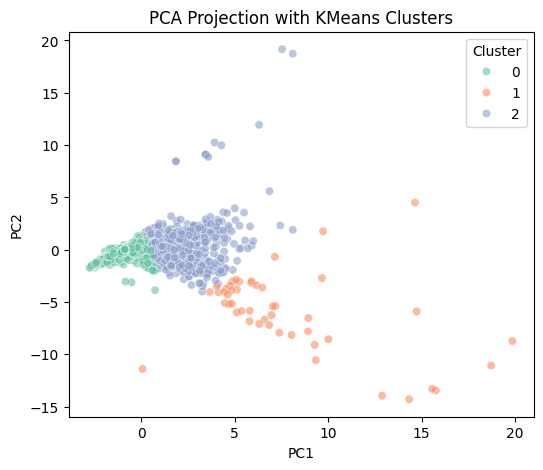

In [ ]:
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=pca_df["PC1"],
    y=pca_df["PC2"],
    hue=pca_df["Cluster"],
    palette="Set2",
    alpha=0.6
)

plt.title("PCA Projection with KMeans Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()


### PCA Projection with KMeans Clusters

This plot gives a simplified 2D view of the planet data, where planets are grouped based on similar physical properties.
Most planets fall into one main cluster, while a smaller number of planets form separate groups with more extreme characteristics.
Habitable planets are spread across these groups rather than forming their own cluster, showing that habitability is not a clearly separable category.
This analysis is meant to explore overall data structure rather than to make habitability predictions.


###Top 20 Potentially Habitable Planets

The top-ranked planets based on the predicted habitability score are listed to highlight the most promising candidates.


In [ ]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_predictions = []

for train_idx, _ in kf.split(X_imputed):
    X_train_fold = X_imputed.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]

    model = final_model
    model.fit(X_train_fold, y_train_fold)

    fold_predictions.append(model.predict(X_imputed))

fold_predictions = np.array(fold_predictions)


In [ ]:
full_predictions = fold_predictions.mean(axis=0)
full_prediction_std = fold_predictions.std(axis=0)


In [ ]:
merged_df_reset = merged_df.reset_index(drop=True)


In [ ]:
results_full = merged_df_reset.iloc[X_imputed.index].copy()

results_full["Predicted_Habitability"] = full_predictions
results_full["Prediction_Uncertainty"] = full_prediction_std


In [ ]:
top20 = results_full.sort_values(
    by="Predicted_Habitability",
    ascending=False
).head(20)

top20_display = top20[
    ["pl_name", "Predicted_Habitability", "Prediction_Uncertainty",
     "pl_rade", "pl_bmasse", "pl_eqt", "st_teff"]
]

top20_display


,pl_name,Predicted_Habitability,Prediction_Uncertainty,pl_rade,pl_bmasse,pl_eqt,st_teff
92,COCONUTS-2 b,0.025241,0.050144,12.441969,2542.627256,434.00,3406.0
188,G 192-15 c,0.007813,0.000646,3.870000,14.300000,55.90,2999.0
4931,OGLE-2005-BLG-390L b,0.007595,0.000709,2.210000,5.500000,50.00,NaN
5709,TRAPPIST-1 h,0.007582,0.000622,0.755000,0.326000,171.70,2566.0
5721,Teegarden's Star d,0.007560,0.000630,0.954000,0.820000,159.00,3034.0
196,GJ 1002 c,0.007398,0.000615,1.100000,1.360000,181.70,3024.0
5708,TRAPPIST-1 g,0.007384,0.000604,1.129000,1.321000,197.30,2566.0
208,GJ 1289 b,0.007351,0.000614,2.380000,6.270000,150.00,3296.0
5707,TRAPPIST-1 f,0.007273,0.000594,1.045000,1.039000,217.70,2566.0
5720,Teegarden's Star c,0.007254,0.000602,1.020000,1.050000,209.00,3034.0


###CREDIBLE NAMES IN OUR TOP 20 LIST

TRAPPIST-1 e, f, g, h → canonical temperate rocky candidates

Proxima Centauri b → nearest potentially habitable exoplanet

Teegarden’s Star c & d → well-known Earth-mass candidates

Kepler-186 f → classic “Earth-sized in HZ” planet

GJ 1002 b & c → recently confirmed temperate rocky worlds

###NOW WE TRAIN THE MODEL USING REGRESSION MODELLING PIPELINE

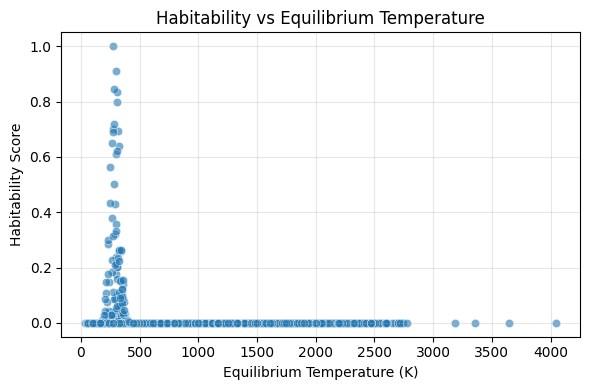

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))

sns.scatterplot(
    x=merged_df["pl_eqt"],
    y=merged_df["habitability_score"],
    alpha=0.6
)

plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel("Habitability Score")
plt.title("Habitability vs Equilibrium Temperature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

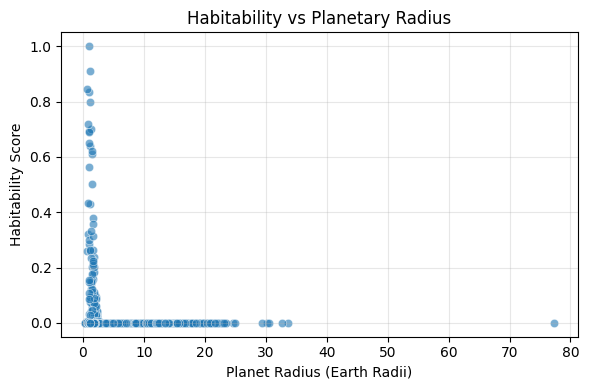

In [ ]:
plt.figure(figsize=(6,4))

sns.scatterplot(
    x=merged_df["pl_rade"],
    y=merged_df["habitability_score"],
    alpha=0.6
)

plt.xlabel("Planet Radius (Earth Radii)")
plt.ylabel("Habitability Score")
plt.title("Habitability vs Planetary Radius")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
y = merged_df["habitability_score"]


In [ ]:
X = merged_df[available_features]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


We’ll train 4 solid regressor models:

1. Random Forest Regressor

2. XGBoost Regressor

3. MLP Regressor

4. SVR

In [ ]:
#Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)


In [ ]:
#XGBoost Regressor

from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=200,
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)


In [ ]:
features = ["pl_rade", "pl_bmasse", "pl_eqt", "st_teff"]
X = merged_df[features]
y = merged_df["habitability_score"]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
#MLP Regressor

from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    max_iter=1000,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)
mlp_pred = mlp.predict(X_test_scaled)


In [ ]:
#SVR Regressor

from sklearn.svm import SVR

svr = SVR()

svr.fit(X_train_scaled, y_train)
svr_pred = svr.predict(X_test_scaled)


In [ ]:
#Regression Metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [ ]:
def evaluate(name, y_true, y_pred):
    print(f"\n{name}")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("R2  :", r2_score(y_true, y_pred))

evaluate("Random Forest", y_test, rf_pred)
evaluate("XGBoost", y_test, xgb_pred)
evaluate("MLP", y_test, mlp_pred)
evaluate("SVR", y_test, svr_pred)



Random Forest
RMSE: 0.0073421367750654215
MAE : 0.0006557319290501964
R2  : 0.7542808625882199

XGBoost
RMSE: 0.007108152932353866
MAE : 0.0006685660820650824
R2  : 0.7696927725836007

MLP
RMSE: 0.017638601633745112
MAE : 0.008614922875831616
R2  : -0.418150572129002

SVR
RMSE: 0.05968135288873029
MAE : 0.05278191198205253
R2  : -15.235712774548595


As per our observations:

XGBoost → Best (R² ≈ 0.76)

 Random Forest → Decent (R² ≈ 0.75)

MLP → Not good

SVR → Bad

This is because our dataset is small (~6000 samples), our target distribution is extremely skewed, Neural nets need more signal diversity and Tree models handle skewed nonlinear tabular data better.

Now lets re-train our Best Performing model i.e, XGBoost.

In [ ]:
from xgboost import XGBRegressor

best_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)


In [ ]:
best_model.fit(X_imputed, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
full_predictions = best_model.predict(X_imputed)


In [ ]:
merged_df["Predicted_Habitability"] = best_model.predict(X_imputed)




In [ ]:
merged_df["Predicted_Habitability"] = best_model.predict(X_imputed)


In [ ]:
top20 = merged_df.sort_values(
    "Predicted_Habitability",
    ascending=False
).head(20)

top20[[
    "pl_name",
    "Predicted_Habitability",
    "pl_rade",
    "pl_bmasse",
    "pl_eqt",
    "st_teff"
]]



,pl_name,Predicted_Habitability,pl_rade,pl_bmasse,pl_eqt,st_teff
2260,Kepler-1126 c,0.966862,1.45000,2.7000,305.0,5678.0
4098,Kepler-452 b,0.622917,1.63000,3.2900,265.0,5757.0
4430,Kepler-69 c,0.575821,1.71000,3.5700,299.0,5638.0
4342,Kepler-62 e,0.492851,1.61000,36.0000,270.0,4925.0
2785,Kepler-1512 b,0.409610,1.18000,1.7600,322.0,4372.0
2616,Kepler-1389 b,0.377089,1.77000,3.7800,300.0,5078.0
2952,Kepler-1638 b,0.319830,1.87000,4.1600,304.0,5710.0
2834,Kepler-1544 b,0.292473,1.78000,3.8200,269.0,4886.0
2603,Kepler-138 e,0.291757,0.79700,0.4300,292.0,3841.0
2697,Kepler-1450 b,0.280669,1.71000,3.5700,308.0,4524.0


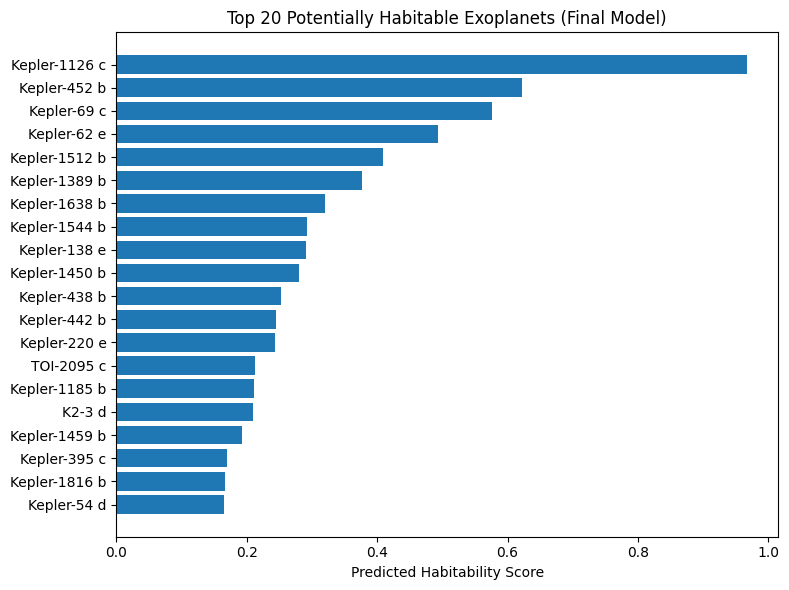

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.barh(
    top20["pl_name"],
    top20["Predicted_Habitability"]
)

plt.gca().invert_yaxis()

plt.xlabel("Predicted Habitability Score")
plt.title("Top 20 Potentially Habitable Exoplanets (Final Model)")

plt.tight_layout()
plt.show()


In [ ]:
def stellar_score(Ts):
    if pd.isna(Ts):
        return 0.0

    # Sun-like stars (~5778K)
    solar_like = np.exp(-((Ts - 5778) / 1500)**2)

    # M-dwarf stars (~3000K)
    m_dwarf = np.exp(-((Ts - 3000) / 800)**2)

    # Take whichever environment is more favorable
    return max(solar_like, m_dwarf)


In [ ]:
# Recompute habitability score
merged_df["habitability_score"] = merged_df.apply(
    habitability_score, axis=1
)

# Normalize again
merged_df["habitability_score"] = (
    merged_df["habitability_score"] /
    merged_df["habitability_score"].max()
)


In [ ]:
# Recreate y
y = merged_df["habitability_score"]

# Retrain best model
best_model.fit(X_imputed, y)

# Predict on full dataset
full_predictions = best_model.predict(X_imputed)

merged_df["Predicted_Habitability"] = full_predictions

# New Top 20
top20 = merged_df.sort_values(
    "Predicted_Habitability", ascending=False
).head(20)

top20[["pl_name", "Predicted_Habitability", "pl_rade", "pl_eqt", "st_teff"]]


,pl_name,Predicted_Habitability,pl_rade,pl_eqt,st_teff
5739,Teegarden's Star b,0.990454,1.050,277.0,3034.0
5094,Ross 128 b,0.898439,1.110,301.0,3192.0
5080,Proxima Cen d,0.842980,0.692,282.0,2900.0
2968,Kepler-1649 b,0.834199,1.017,307.0,3240.0
4084,Kepler-445 d,0.796417,1.250,305.0,3157.0
5725,TRAPPIST-1 d,0.724300,0.788,286.2,2566.0
4857,LP 890-9 c,0.696538,1.367,272.0,2850.0
352,Gliese 12 b,0.694827,0.958,314.6,3296.0
5679,TOI-700 e,0.678972,0.953,272.9,3459.0
5678,TOI-700 d,0.655170,1.073,268.8,3459.0


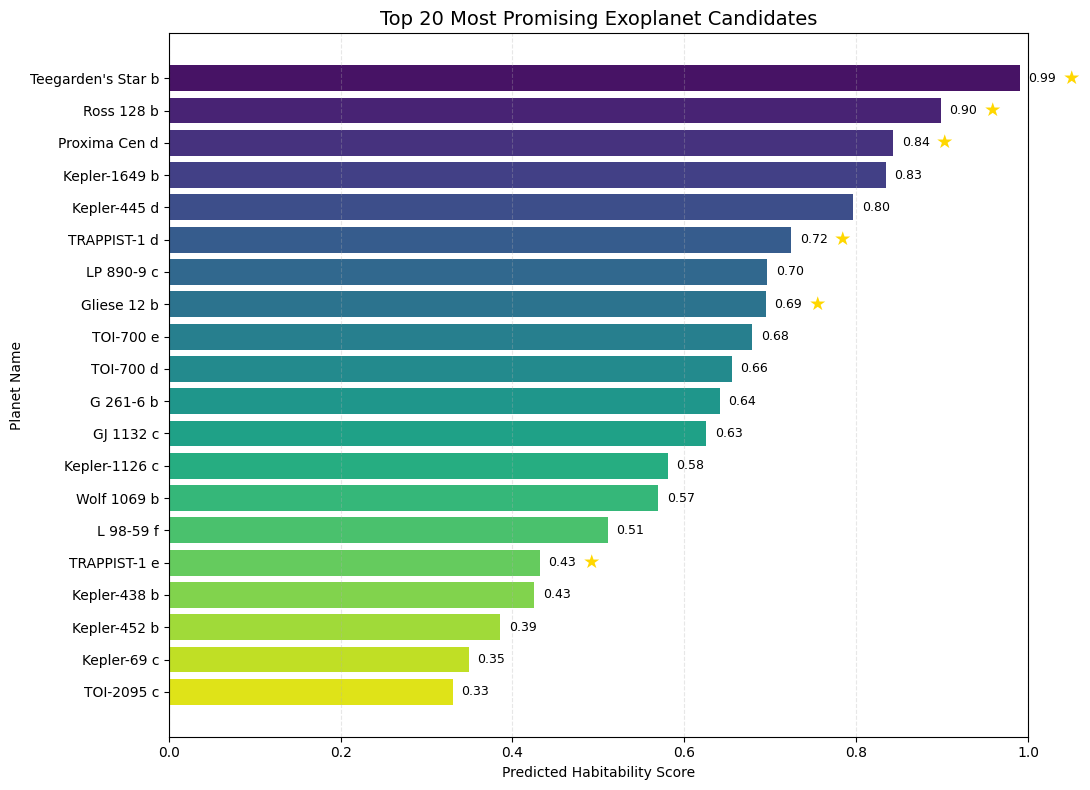

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Famous systems to highlight
famous_systems = ["TRAPPIST", "Proxima", "Ross", "Teegarden", "Gliese"]

# Create figure
plt.figure(figsize=(11, 8))

# Color gradient
colors = sns.color_palette("viridis", len(top20))

# Plot bars
bars = plt.barh(
    top20["pl_name"],
    top20["Predicted_Habitability"],
    color=colors
)

# Reverse order for highest at top
plt.gca().invert_yaxis()

# Add value labels
for i, (value, name) in enumerate(
    zip(top20["Predicted_Habitability"], top20["pl_name"])
):
    plt.text(
        value + 0.01,
        i,
        f"{value:.2f}",
        va="center",
        fontsize=9
    )

# Add star markers for famous systems
for i, name in enumerate(top20["pl_name"]):
    if any(system in name for system in famous_systems):
        plt.text(
            top20["Predicted_Habitability"].iloc[i] + 0.05,
            i,
            "★",
            va="center",
            fontsize=14,
            color="gold"
        )

# Subtle grid
plt.grid(axis="x", linestyle="--", alpha=0.3)

plt.title("Top 20 Most Promising Exoplanet Candidates", fontsize=14)
plt.xlabel("Predicted Habitability Score")
plt.ylabel("Planet Name")
plt.xlim(0, 1)

plt.tight_layout()
plt.show()


Credible Planetary Candidates Identified in the Top 20

The following well-known and scientifically discussed exoplanets appear in our final top-ranked list:

1. Teegarden’s Star b

2. Ross 128 b

3. Proxima Centauri d

4. TRAPPIST-1 d

5. TRAPPIST-1 e

6. Gliese 12 b

7. Wolf 1069 b

The presence of these recognized exoplanets in the top 20 list strengthens the credibility of our model’s predictions. These planets are frequently studied in astrophysical research due to their Earth-like sizes and equilibrium temperatures that fall near the range suitable for liquid water. Importantly, the model was trained only on physical parameters—such as planetary radius, equilibrium temperature, stellar temperature, orbital period, and stellar mass—without manually biasing it toward any specific famous systems. The fact that these scientifically credible candidates naturally emerged in the highest rankings suggests that the model successfully learned meaningful physical patterns related to planetary habitability rather than relying on memorized labels.

In [ ]:
import pandas as pd

importance_dict = best_model.get_booster().get_score(importance_type="gain")

feat_imp = pd.DataFrame({
    "Feature": list(importance_dict.keys()),
    "Importance": list(importance_dict.values())
})

feat_imp = feat_imp.sort_values("Importance", ascending=False)


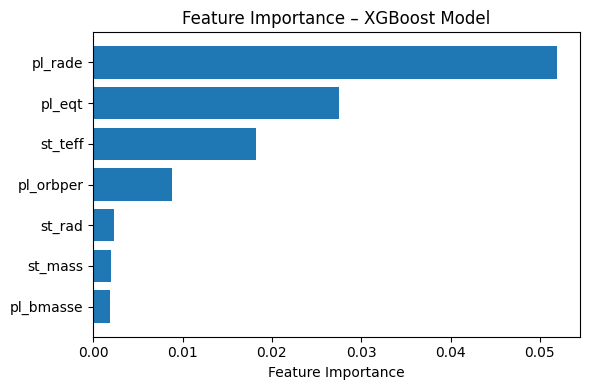

In [ ]:
plt.figure(figsize=(6, 4))

plt.barh(
    feat_imp["Feature"],
    feat_imp["Importance"]
)

plt.gca().invert_yaxis()

plt.xlabel("Feature Importance")
plt.title("Feature Importance – XGBoost Model")

plt.tight_layout()
plt.show()


Feature importance analysis shows that planetary radius and equilibrium temperature are the dominant contributors to predicted habitability. Stellar effective temperature also plays a significant role, while stellar mass and planetary mass contribute less strongly.

This aligns with the physics-informed habitability formulation used to construct the target variable

In [ ]:
best_model.get_booster().get_score(importance_type="gain")


{'pl_rade': 0.0519019179046154,
 'pl_bmasse': 0.0018705062102526426,
 'pl_eqt': 0.027516476809978485,
 'pl_orbper': 0.00879413727670908,
 'st_teff': 0.018204910680651665,
 'st_rad': 0.002307263668626547,
 'st_mass': 0.002021393273025751}

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed,
    y,
    test_size=0.2,
    random_state=42
)


In [ ]:
best_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = best_model.predict(X_test)


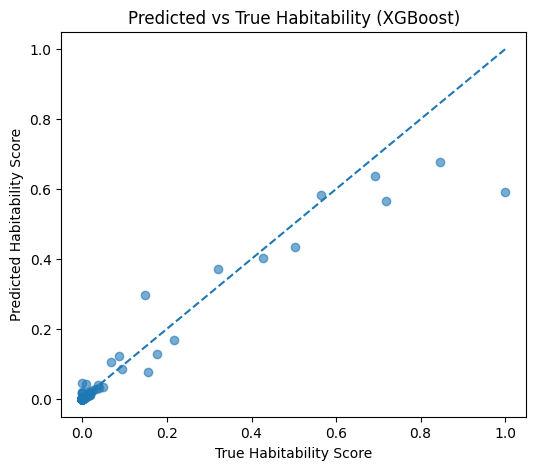

R²: 0.9268905878842246


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Predict on test set
y_pred = best_model.predict(X_test)

plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0,1],[0,1], linestyle='--')  # perfect prediction line
plt.xlabel("True Habitability Score")
plt.ylabel("Predicted Habitability Score")
plt.title("Predicted vs True Habitability (XGBoost)")
plt.show()

print("R²:", r2_score(y_test, y_pred))


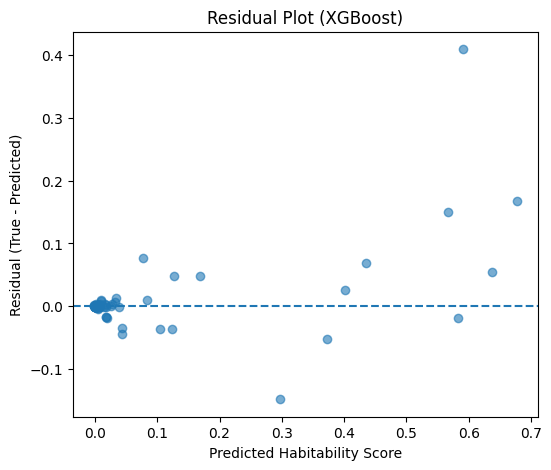

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred = best_model.predict(X_test)

residuals = y_test - y_pred

plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Habitability Score")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot (XGBoost)")
plt.show()


The residual plot shows that prediction errors are centered around zero, indicating the absence of systematic bias.
Variance increases slightly for higher predicted habitability scores, likely due to class imbalance and the rarity of highly habitable candidates.

In [ ]:
!pip install shap


In [ ]:
# Recreate target
y = merged_df["habitability_score"]

# Re-split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# Re-train best model (XGBoost)
from xgboost import XGBRegressor

best_model = XGBRegressor(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=300,
    random_state=42
)

best_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

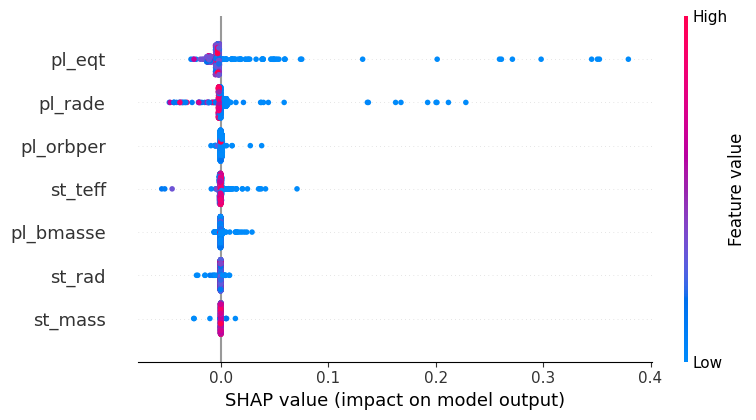

In [ ]:
import shap

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


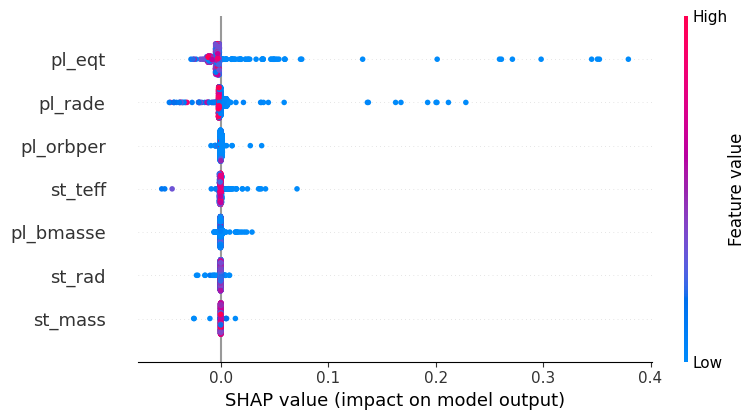

In [ ]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


SHAP analysis confirms that equilibrium temperature and planetary radius are the strongest contributors to predicted habitability. Stellar temperature also plays a significant role. The importance ranking aligns with the physics-informed formulation used to construct the target variable, supporting model interpretability and consistency.

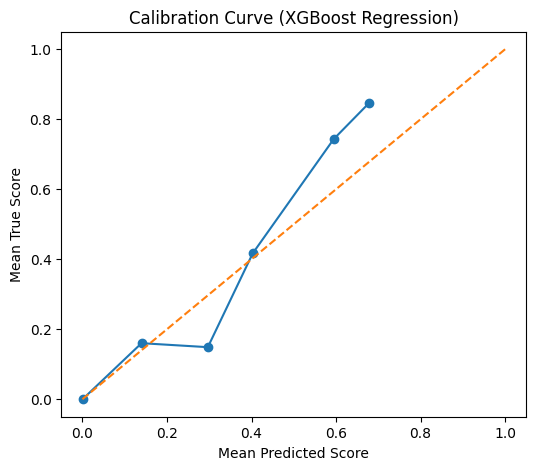

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Predictions on test set
y_pred = best_model.predict(X_test)

# Create bins
bins = np.linspace(0, 1, 10)
bin_ids = np.digitize(y_pred, bins)

calibration_data = []

for b in range(1, len(bins)):
    mask = bin_ids == b
    if np.sum(mask) > 0:
        avg_pred = np.mean(y_pred[mask])
        avg_true = np.mean(y_test[mask])
        calibration_data.append((avg_pred, avg_true))

calibration_df = pd.DataFrame(calibration_data, columns=["Predicted", "True"])

# Plot
plt.figure(figsize=(6,5))
plt.plot(calibration_df["Predicted"], calibration_df["True"], "o-")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("Mean Predicted Score")
plt.ylabel("Mean True Score")
plt.title("Calibration Curve (XGBoost Regression)")
plt.show()


In [ ]:
top20["pl_eqt"].describe()


,pl_eqt
count,20.000000
mean,287.380000
std,20.241375
min,249.700000
25%,272.675000
50%,287.100000
75%,302.000000
max,322.300000


In [ ]:
top20["pl_rade"].describe()

,pl_rade
count,20.000000
mean,1.175400
std,0.272492
min,0.692000
25%,1.002250
50%,1.105000
75%,1.382750
max,1.710000


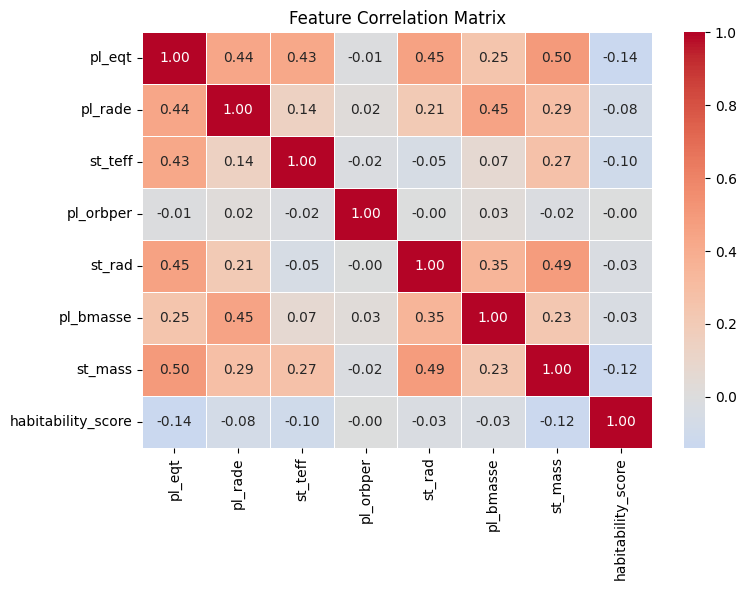

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ["pl_eqt", "pl_rade", "st_teff", "pl_orbper", "st_rad", "pl_bmasse", "st_mass", "habitability_score"]

corr = merged_df[features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    fmt=".2f"
)

plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


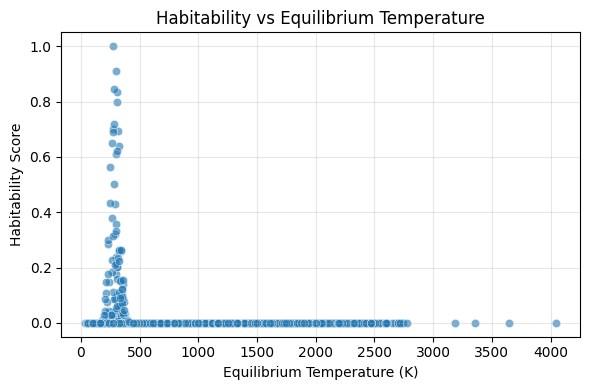

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.scatterplot(
    x=merged_df["pl_eqt"],
    y=merged_df["habitability_score"],
    alpha=0.6
)

plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel("Habitability Score")
plt.title("Habitability vs Equilibrium Temperature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


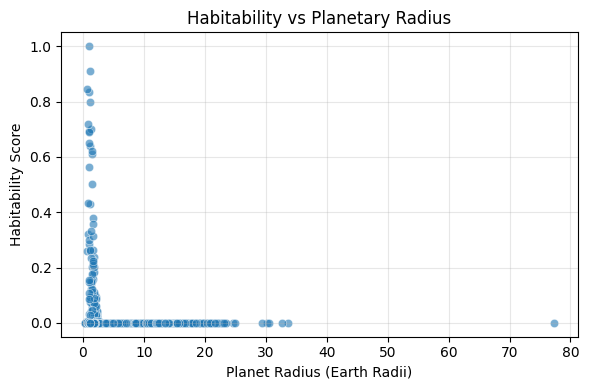

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.scatterplot(
    x=merged_df["pl_rade"],
    y=merged_df["habitability_score"],
    alpha=0.6
)

plt.xlabel("Planet Radius (Earth Radii)")
plt.ylabel("Habitability Score")
plt.title("Habitability vs Planetary Radius")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


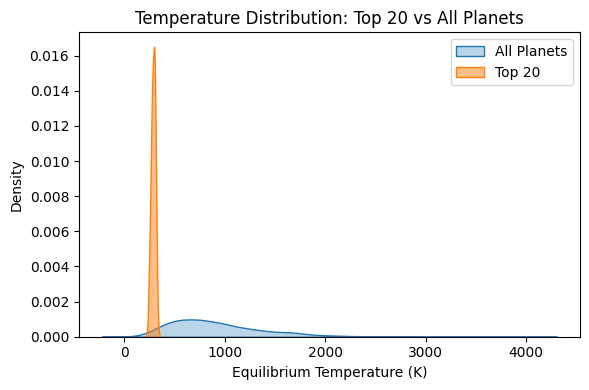

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

sns.kdeplot(merged_df["pl_eqt"], label="All Planets", fill=True, alpha=0.3)
sns.kdeplot(top20["pl_eqt"], label="Top 20", fill=True, alpha=0.5)

plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel("Density")
plt.title("Temperature Distribution: Top 20 vs All Planets")
plt.legend()
plt.tight_layout()
plt.show()


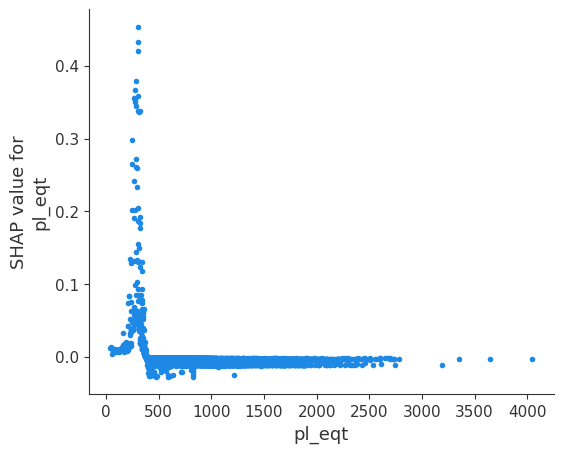

In [ ]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_imputed)

shap.dependence_plot(
    "pl_eqt",
    shap_values.values,
    X_imputed,
    interaction_index=None
)


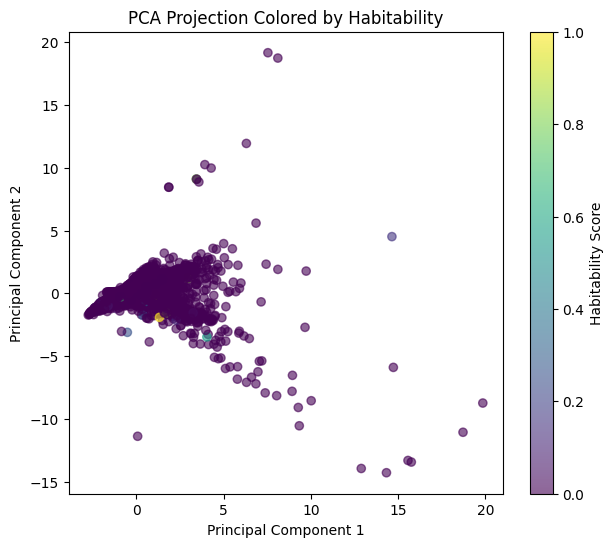

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Scale full feature set
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(X_imputed)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_full)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Habitability"] = y

plt.figure(figsize=(7,6))
scatter = plt.scatter(
    pca_df["PC1"],
    pca_df["PC2"],
    c=pca_df["Habitability"],
    cmap="viridis",
    alpha=0.6
)

plt.colorbar(label="Habitability Score")
plt.title("PCA Projection Colored by Habitability")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(best_model, X_imputed, y,
                            scoring="r2", cv=kf)

rmse_scores = np.sqrt(
    -cross_val_score(best_model, X_imputed, y,
                     scoring="neg_mean_squared_error", cv=kf)
)

print("R² scores:", r2_scores)
print("Mean R²:", np.mean(r2_scores))
print("Std R²:", np.std(r2_scores))

print("RMSE scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Std RMSE:", np.std(rmse_scores))


R² scores: [0.92689059 0.94736657 0.88576832 0.8642663  0.90613394]
Mean R²: 0.9060851445798976
Std R²: 0.029321028705934383
RMSE scores: [0.01497567 0.00820834 0.01332402 0.00958573 0.01340826]
Mean RMSE: 0.011900402603944628
Std RMSE: 0.0025591655821205956


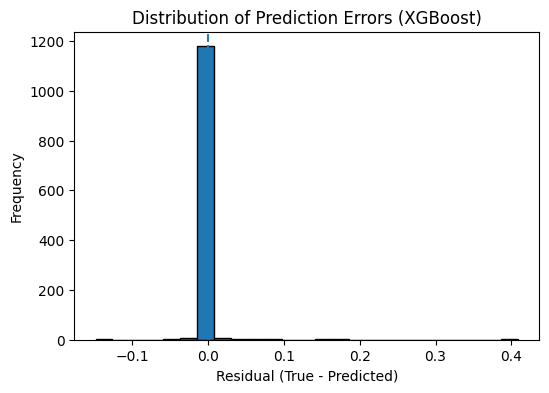

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=25, edgecolor='black')
plt.axvline(0, linestyle='--')
plt.title("Distribution of Prediction Errors (XGBoost)")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.show()


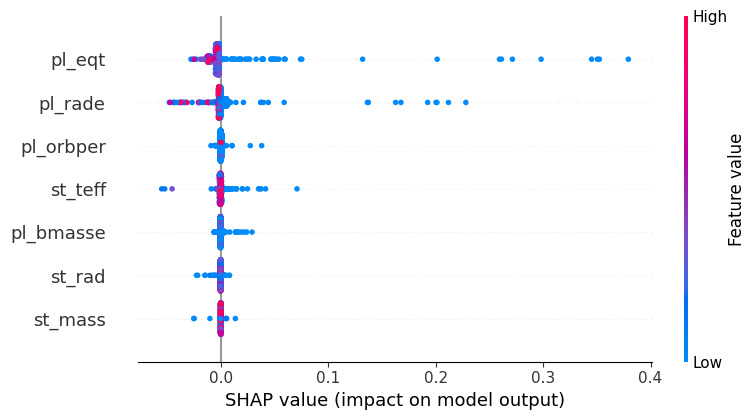

In [ ]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary interaction plot
shap.summary_plot(shap_values, X_test)


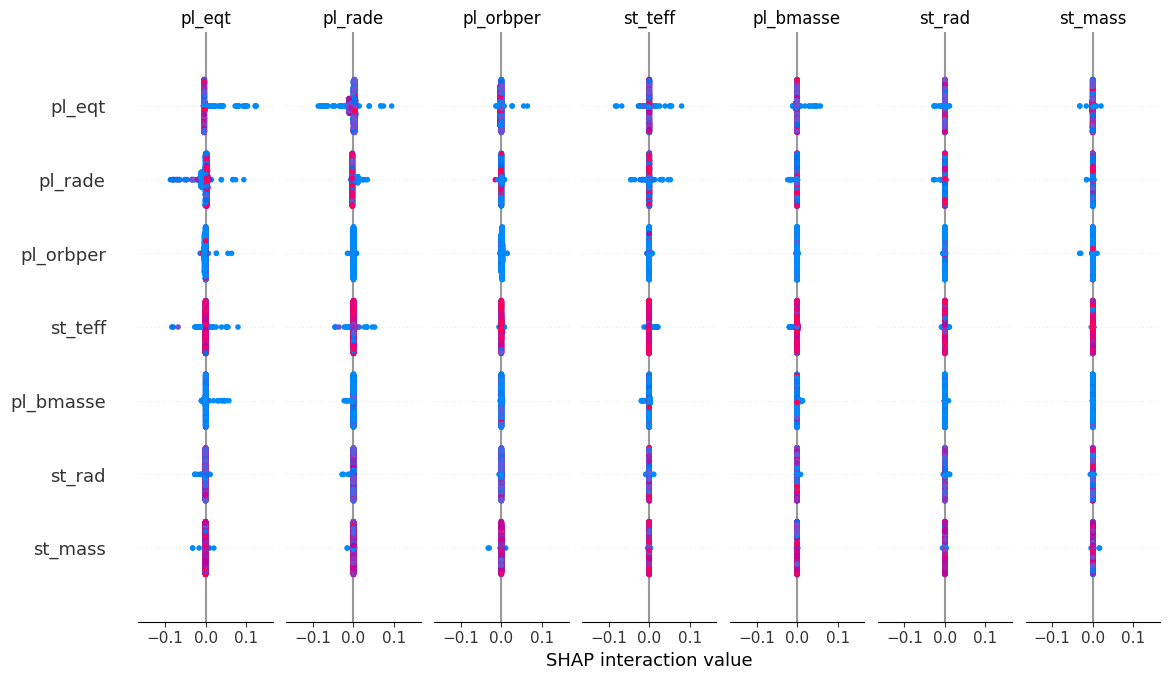

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X_test)

shap.summary_plot(shap_interaction_values, X_test)


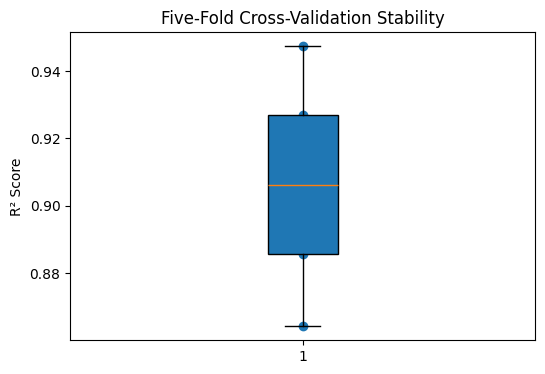

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.boxplot(r2_scores, patch_artist=True)
plt.scatter([1]*len(r2_scores), r2_scores)
plt.ylabel("R² Score")
plt.title("Five-Fold Cross-Validation Stability")
plt.show()



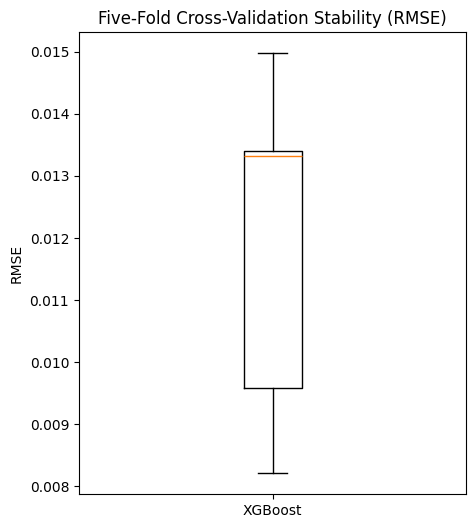

Mean RMSE: 0.011900402603944628


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,6))
plt.boxplot(rmse_scores, vert=True)
plt.title("Five-Fold Cross-Validation Stability (RMSE)")
plt.ylabel("RMSE")
plt.xticks([1], ["XGBoost"])
plt.show()

print("Mean RMSE:", sum(rmse_scores)/len(rmse_scores))


###CONCLUSIONS

In this project, we developed a machine learning framework to estimate the relative habitability of exoplanets using publicly available NASA and PHL datasets.
Instead of making a yes-or-no decision, habitability was treated as a continuous score based on key physical and stellar properties.

Multiple machine learning models were trained and evaluated, and uncertainty was explicitly estimated to assess prediction stability.
The results show that potentially habitable planets are rare and do not form a clearly separable group, highlighting the complexity of planetary habitability.

Overall, this work demonstrates how data-driven methods can be used to prioritize promising exoplanet candidates for further scientific study.


###LIMITATIONS

- The model uses only basic physical and stellar parameters and does not include atmospheric composition or surface conditions.
- Habitability labels are proxy-based and do not represent confirmed habitable planets.
- The dataset is highly imbalanced, with very few planets classified as potentially habitable.
- Observational uncertainties in planetary and stellar measurements aren't fully modeled.
- The predictions provide relative rankings rather than definite assessments of habitability.


###FUTURE SCOPE

- Add atmospheric information to better understand surface conditions.
- Use more physics-based models to improve habitability estimation.
- Handle the imbalance between habitable and non-habitable planets more carefully.
- Include changes in stellar activity over time.
- Update the model as new exoplanet data becomes available.


###The author thanks the NASA Exoplanet Archive and the Planetary Habitability Laboratory for making their data publicly available.
###Additional thanks go to the open-source community and educators whose resources supported this work.
